<a href="https://colab.research.google.com/github/codsalah/Machine-Learning-Projects/blob/main/Classification_of_Bone_Tumor_(max_score_0_8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bone-tumor:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3711136%2F6538980%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240410%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240410T235207Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9ac48afd9d73d45cafe3b0c2f43ee18f7f062597cc5f75717607beb12d291a8f22d158eced3f6576a22facd2ce22422ca70c683c0dbe4f2e55fe08747927b3219fe65e6cb33d46fe8acb093dee06310ccdaf22e7858b153571454c44c5d8a99bd68e889834ddf34477a6f2fa92debf6f6b75d1beb93b5d3386947a99369358d00f8425344518a92571bf57f27e9d5b4da4ac168b4091de5c0344d9bc0a5e2f623cacd5ad934a1ddf2abff95cfca7a9c5b3e56dd075126df972cba93c7bde4ee7c215f7a25707011a3353bfe0bf3a771c8f8691afab4b4875293a5b611ed0a069388549c6f97105b82db80faaf6e98c7408a29975caedfe8d6743bfae467d3f60'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5213 bytes downloaded
Downloaded and uncompressed: bone-tumor
Data source import complete.


* [1. <span style="font-family: Tahoma;">INTRODUCTION</span>](#1)  
* [2. <span style="font-family: Tahoma;">Import necessary libraries</span>](#2)   
* [3. <span style="font-family: Tahoma;">EDA and Preprocessing</span>](#3)
* [4. <span style="font-family: Tahoma;">Model Creation</span>](#4)
    * [4.1. <span style="font-family: Tahoma;">XGBOOST</span>](#4.1)    
    * [4.2. <span style="font-family: Tahoma;">XGBOOST Confusion Matrix</span>](#4.2)    
    * [4.3. <span style="font-family: Tahoma;">KNeighborsClassifier</span>](#4.3)    
    * [4.4. <span style="font-family: Tahoma;">KNN Confusion Matrix</span>](#4.4)
    * [4.5. <span style="font-family: Tahoma;">RandomForestClassifier</span>](#4.5)
    * [4.6. <span style="font-family: Tahoma;">RF Confusion Matrix</span>](#4.6)
    * [4.7. <span style="font-family: Tahoma;">Hyperparameter Gridsearch</span>](#4.7)
    * [4.8. <span style="font-family: Tahoma;">Best Score Confusion Matrix</span>](#4.8)
* [5. <span style="font-family: Tahoma;">Conclusion</span>](#5)


 <h1 style="background-color:white
;font-family:Arial Black;font-size:225%;text-align:center;border-radius: 15px 50px;">  🦴🧪 bone tumer 🧪🦴  </h1><a id=0></a>

# ![](https://s3.amazonaws.com/static.wd7.us/a/ab/Brown_tumor.gif)

<a id = "1"></a><br>
# Introduction
***

<div style="background-color: #f0f9ff; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Introduction to the Data</h3>
    <ul>
        <li><strong>Patient ID:</strong> A unique identifier for each patient.</li>
        <li><strong>Sex:</strong> The patient's sex.</li>
        <li><strong>Age:</strong> The patient's age at the time of diagnosis.</li>
        <li><strong>Grade:</strong> The grade of the tumor, which is a measure of how aggressive the tumor is.</li>
        <li><strong>Histological type:</strong> The type of tumor, such as osteosarcoma or Ewing sarcoma.</li>
        <li><strong>MSKCC type:</strong> The MSKCC type of the tumor, which is a more specific classification of the tumor.</li>
        <li><strong>Site of primary STS:</strong> The location of the tumor in the bone.</li>
        <li><strong>Status (NED, AWD, D):</strong> The patient's status, which can be NED (no evidence of disease), AWD (alive with disease), or D (dead).</li>
        <li><strong>Treatment:</strong> The treatment that the patient received, such as surgery, radiation therapy, or chemotherapy.</li>
    </ul>
</div>


<a id = "2"></a><br>
# Import necessary libraries.
***

In [2]:
import tensorflow as tf
from tensorflow.keras import layers ,Sequential
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix


## costum palette

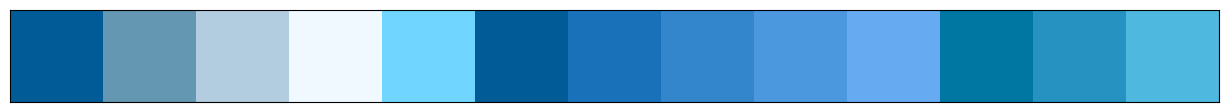

In [3]:
custom_colors = ["#005b96", "#6497b1", "#b3cde0", "#f0f9ff", "#70d6ff", "#005b96", "#1972b9", "#3385cc", "#4c98df", "#66abf2", "#0076a3", "#2592c1", "#4fb8de"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(customPalette), size=1.2)
plt.tick_params(axis='both', labelsize=0, length=0)


<a id = "3"></a><br>
# EDA and Preprocessing
***

In [4]:
df = pd.read_csv('/kaggle/input/bone-tumor/Bone Tumor Dataset.csv')
df.head()

,Patient ID,Sex,Age,Grade,Histological type,MSKCC type,Site of primary STS,"Status (NED, AWD, D)",Treatment
0,STS_001,Female,63,High,pleiomorphic leiomyosarcoma,Leiomyosarcoma,parascapusular,NED,Radiotherapy + Surgery
1,STS_002,Female,54,Intermediate,pleiomorphic leiomyosarcoma,MFH,left thigh,D,Surgery + Chemotherapy
2,STS_003,Male,22,Intermediate,synovial sarcoma,MFH,right buttock,D,Radiotherapy + Surgery
3,STS_004,Female,54,Intermediate,synovial sarcoma,Leiomyosarcoma,right thigh,NED,Radiotherapy + Surgery
4,STS_005,Male,63,High,pleiomorphic spindle cell undifferentiated,MFH,right parascapusular,AWD,Radiotherapy + Surgery + Chemotherapy


<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🚩 Notation :</b> <strong>Treatment column</strong> contains various types of treatments, so I need to separate them into <strong>(n)</strong> columns,
    where <strong>(n)</strong> represents the number of different treatment types.
</div>

I will start with dropping unnecessary data

In [5]:
df = df.drop("Patient ID", axis=1)

lets see some basic information about the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Sex                   500 non-null    object
 1   Age                   500 non-null    int64 
 2   Grade                 500 non-null    object
 3   Histological type     500 non-null    object
 4   MSKCC type            500 non-null    object
 5   Site of primary STS   500 non-null    object
 6   Status (NED, AWD, D)  500 non-null    object
 7   Treatment             500 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.4+ KB


notice that All columns are of the <b> 'object'</b>  data type except for the <b> 'Age'</b>  column, so I need to address that

## value counts

In [7]:
df["Treatment"].value_counts()

Treatment
Radiotherapy + Surgery                   293
Radiotherapy + Surgery + Chemotherapy    143
Surgery + Chemotherapy                    64
Name: count, dtype: int64

we got three types of Treatment that will be One_hot_encoded

In [8]:
df["MSKCC type"].value_counts()

MSKCC type
MFH                 225
Leiomyosarcoma      144
Synovial sarcoma    131
Name: count, dtype: int64

In [9]:
df['Grade'].value_counts()

Grade
Intermediate    282
High            218
Name: count, dtype: int64

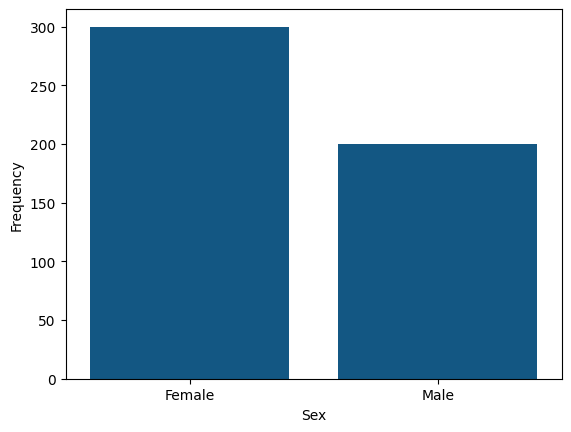

In [10]:
sns.countplot(data = df, x = "Sex" )
plt.ylabel('Frequency');

## Visualizing categorical features

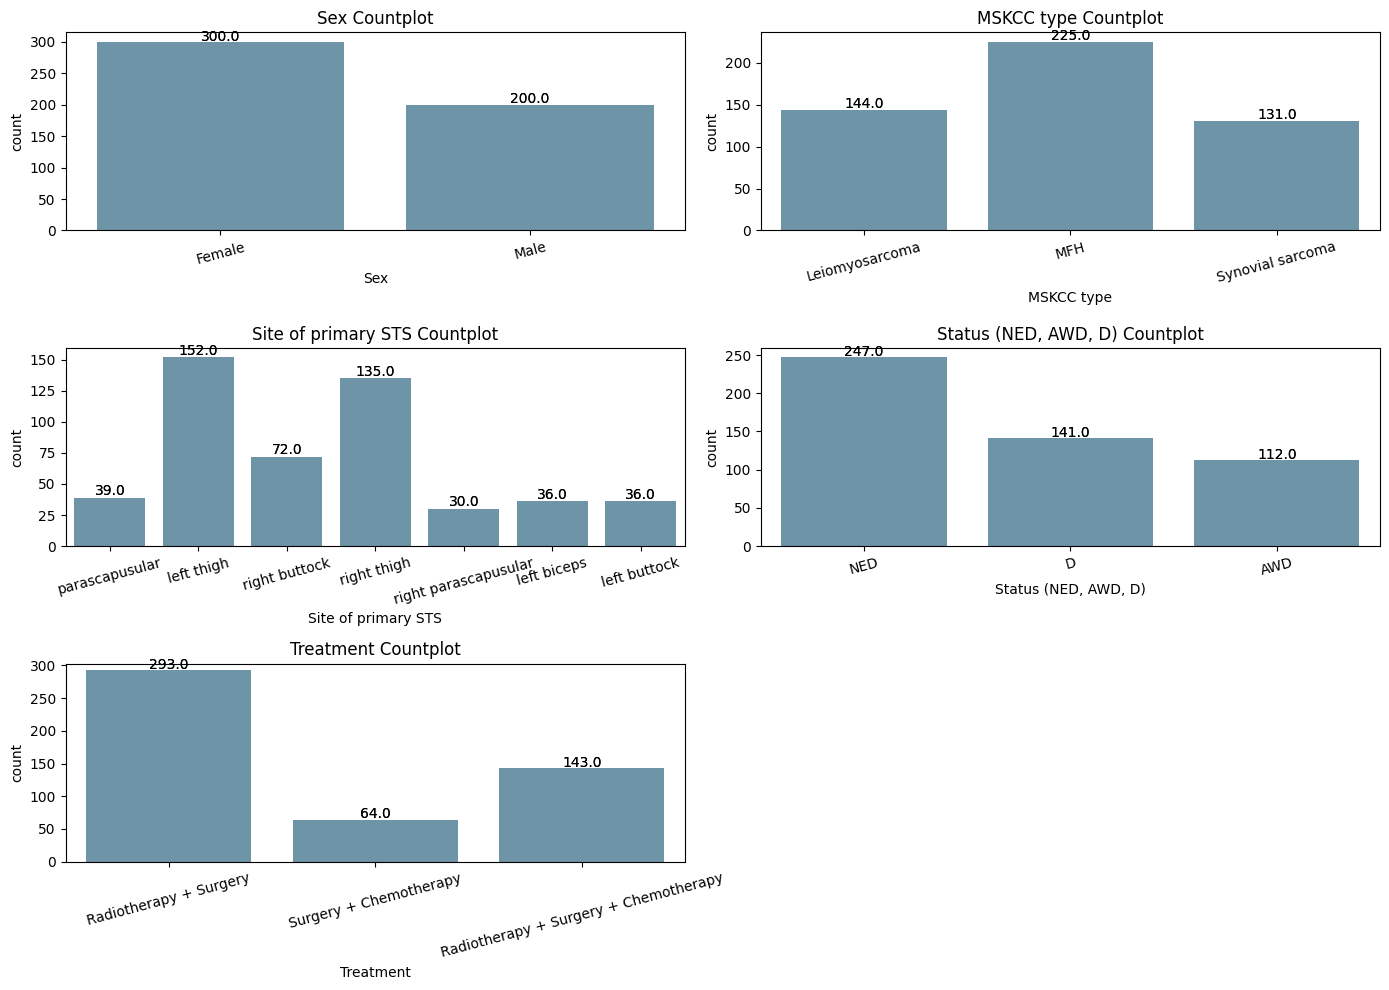

In [11]:
categ_feats = ['Sex', 'MSKCC type',
               'Site of primary STS', 'Status (NED, AWD, D)', 'Treatment']

plt.figure(figsize=(14, len(categ_feats) * 2))

for idx, column in enumerate(categ_feats):
    plt.subplot(len(categ_feats) // 2 + len(categ_feats) % 2, 2, idx + 1)
    sns.countplot(x=column, data=df, palette=customPalette)
    plt.title(f"{column} Countplot")
    plt.xticks(rotation=15)


    for p in sns.countplot(x=column, data=df, palette=customPalette).patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2., height + 2, height, ha="center")

plt.ylim(0, df[column].value_counts().max() + 10)
plt.tight_layout()
plt.show()


<div style="background-color: #f0f9ff; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Summary of analysis</h3>
    <ul>
        <li> <b>Sex</b> : there are 300 cases of bone tumors in females compared to 200 cases in males </li>
        <li><b>Status 2</b> : <b>NED</b> (no evidence of disease) is 247 patient, <b>AWD</b> (alive with disease) 122 patient,and <b>D</b> (dead) 144 death </li>
        <li><b>Treatment</b> : As you can see, surgery is applied in all types of treatments.</li>
        <li><b>STS</b>: We can clearly see that the location of the tumor in the bone <b>is much more frequent in the thigh</b> with 287 patients.</li>
        <li><b>MSkCC</b> : <b>MFH</b> (Malignant Fibrous Histiocytoma): This is the most common type in the dataset with 225 cases
    </ul>
</div>


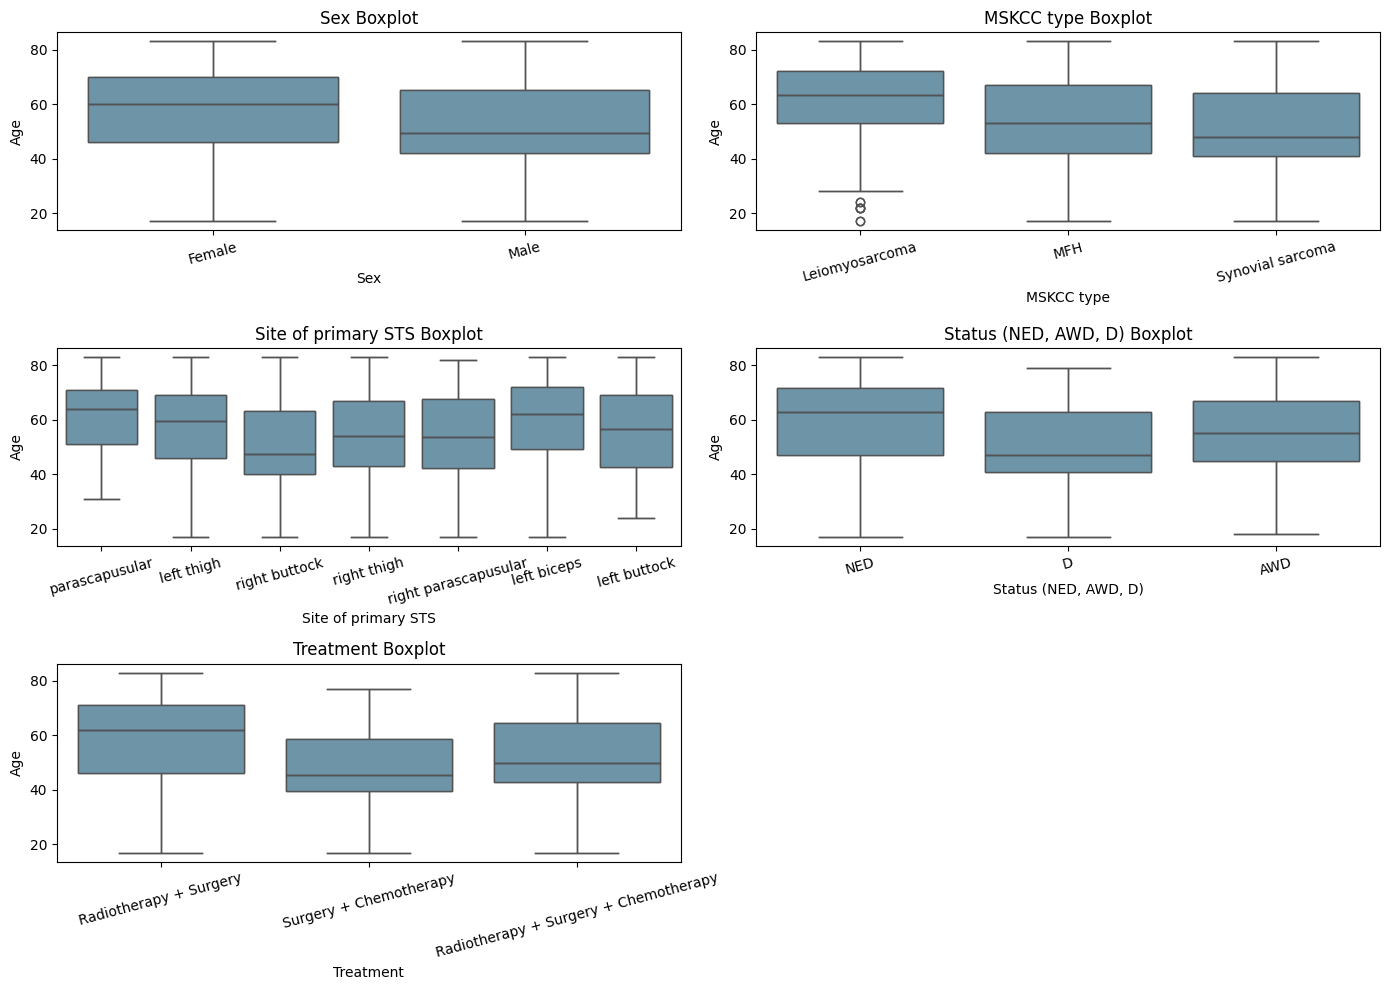

In [12]:
plt.figure(figsize=(14, len(categ_feats) * 2))

for idx, column in enumerate(categ_feats):
    plt.subplot(len(categ_feats) // 2 + len(categ_feats) % 2, 2, idx + 1)

    sns.boxplot(x=column, y='Age', data=df, palette=customPalette)
    plt.title(f"{column} Boxplot")
    plt.xticks(rotation=15)

    for patch in sns.boxplot(x=column, y='Age', data=df, palette=customPalette).artists:
        x = patch.get_x() + patch.get_width() / 2.
        height = patch.get_height()
        plt.text(x, height + 2, height, ha="center")

plt.tight_layout()
plt.show()


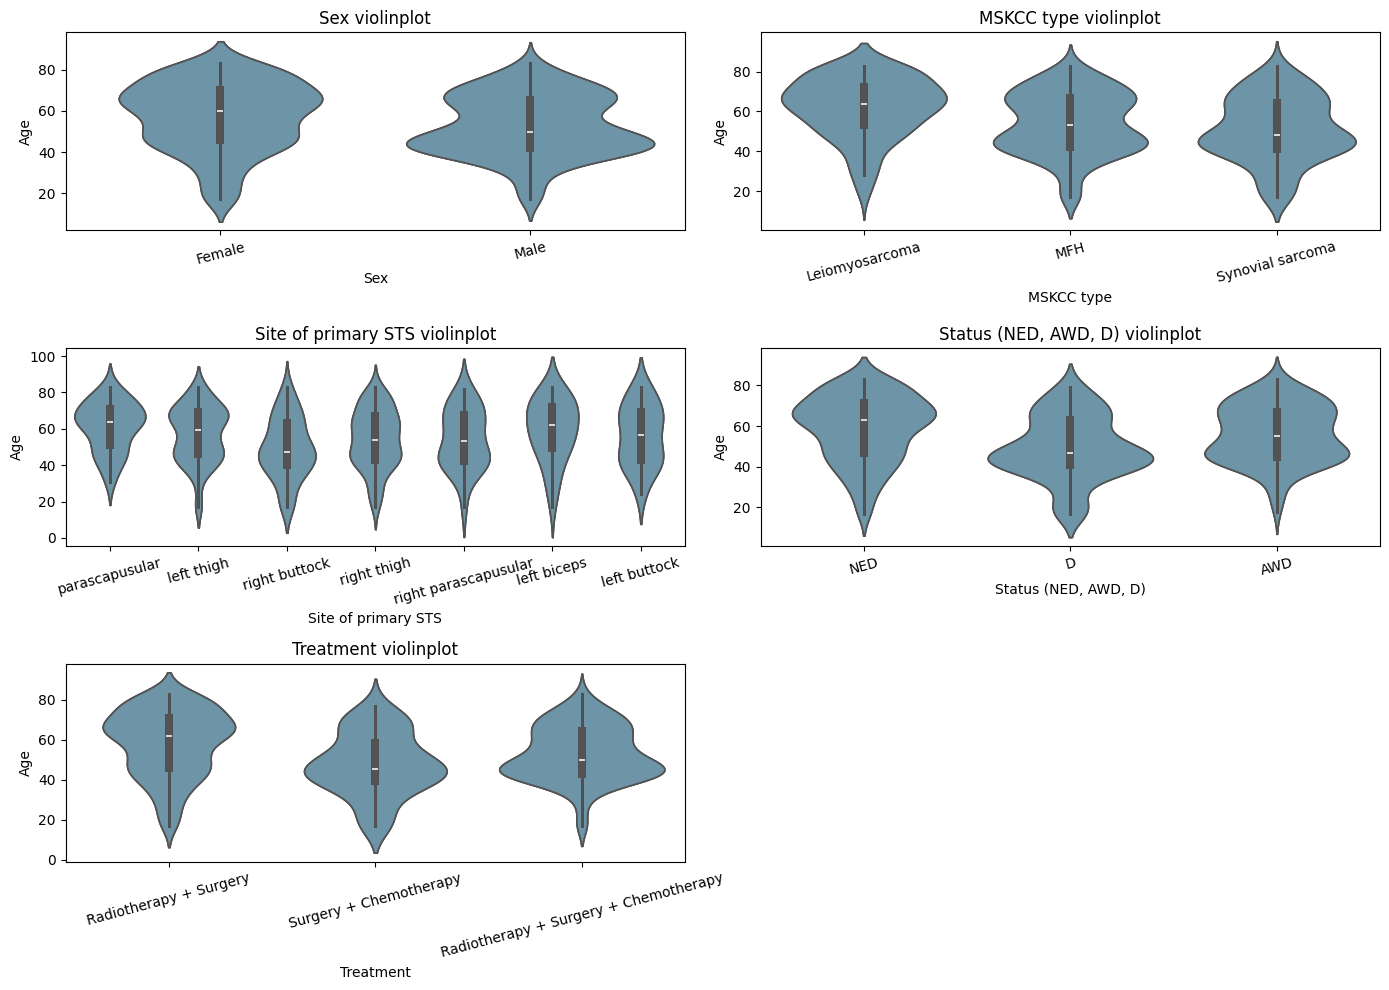

In [13]:
plt.figure(figsize=(14, len(categ_feats) * 2))

for idx, column in enumerate(categ_feats):
    plt.subplot(len(categ_feats) // 2 + len(categ_feats) % 2, 2, idx + 1)

    sns.violinplot(x=column, y='Age', data=df, palette=customPalette)
    plt.title(f"{column} violinplot")
    plt.xticks(rotation=15)

    for patch in sns.violinplot(x=column, y='Age', data=df, palette=customPalette).artists:
        x = patch.get_x() + patch.get_width() / 2.
        height = patch.get_height()
        plt.text(x, height + 2, height, ha="center")

plt.tight_layout()
plt.show()


<div style="background-color: #f0f9ff; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  Summary of analysis</h3>
    <ul>
        <li> <b>Sex</b> : Sex and age are between 40 and 70 for both sexes, but the median differentiates between them, as men tend to experience bone tumor pain earlier than women.</li>
    </ul>
</div>


In [14]:
df.columns

Index(['Sex', 'Age', 'Grade', 'Histological type', 'MSKCC type',
       'Site of primary STS', 'Status (NED, AWD, D)', 'Treatment'],
      dtype='object')

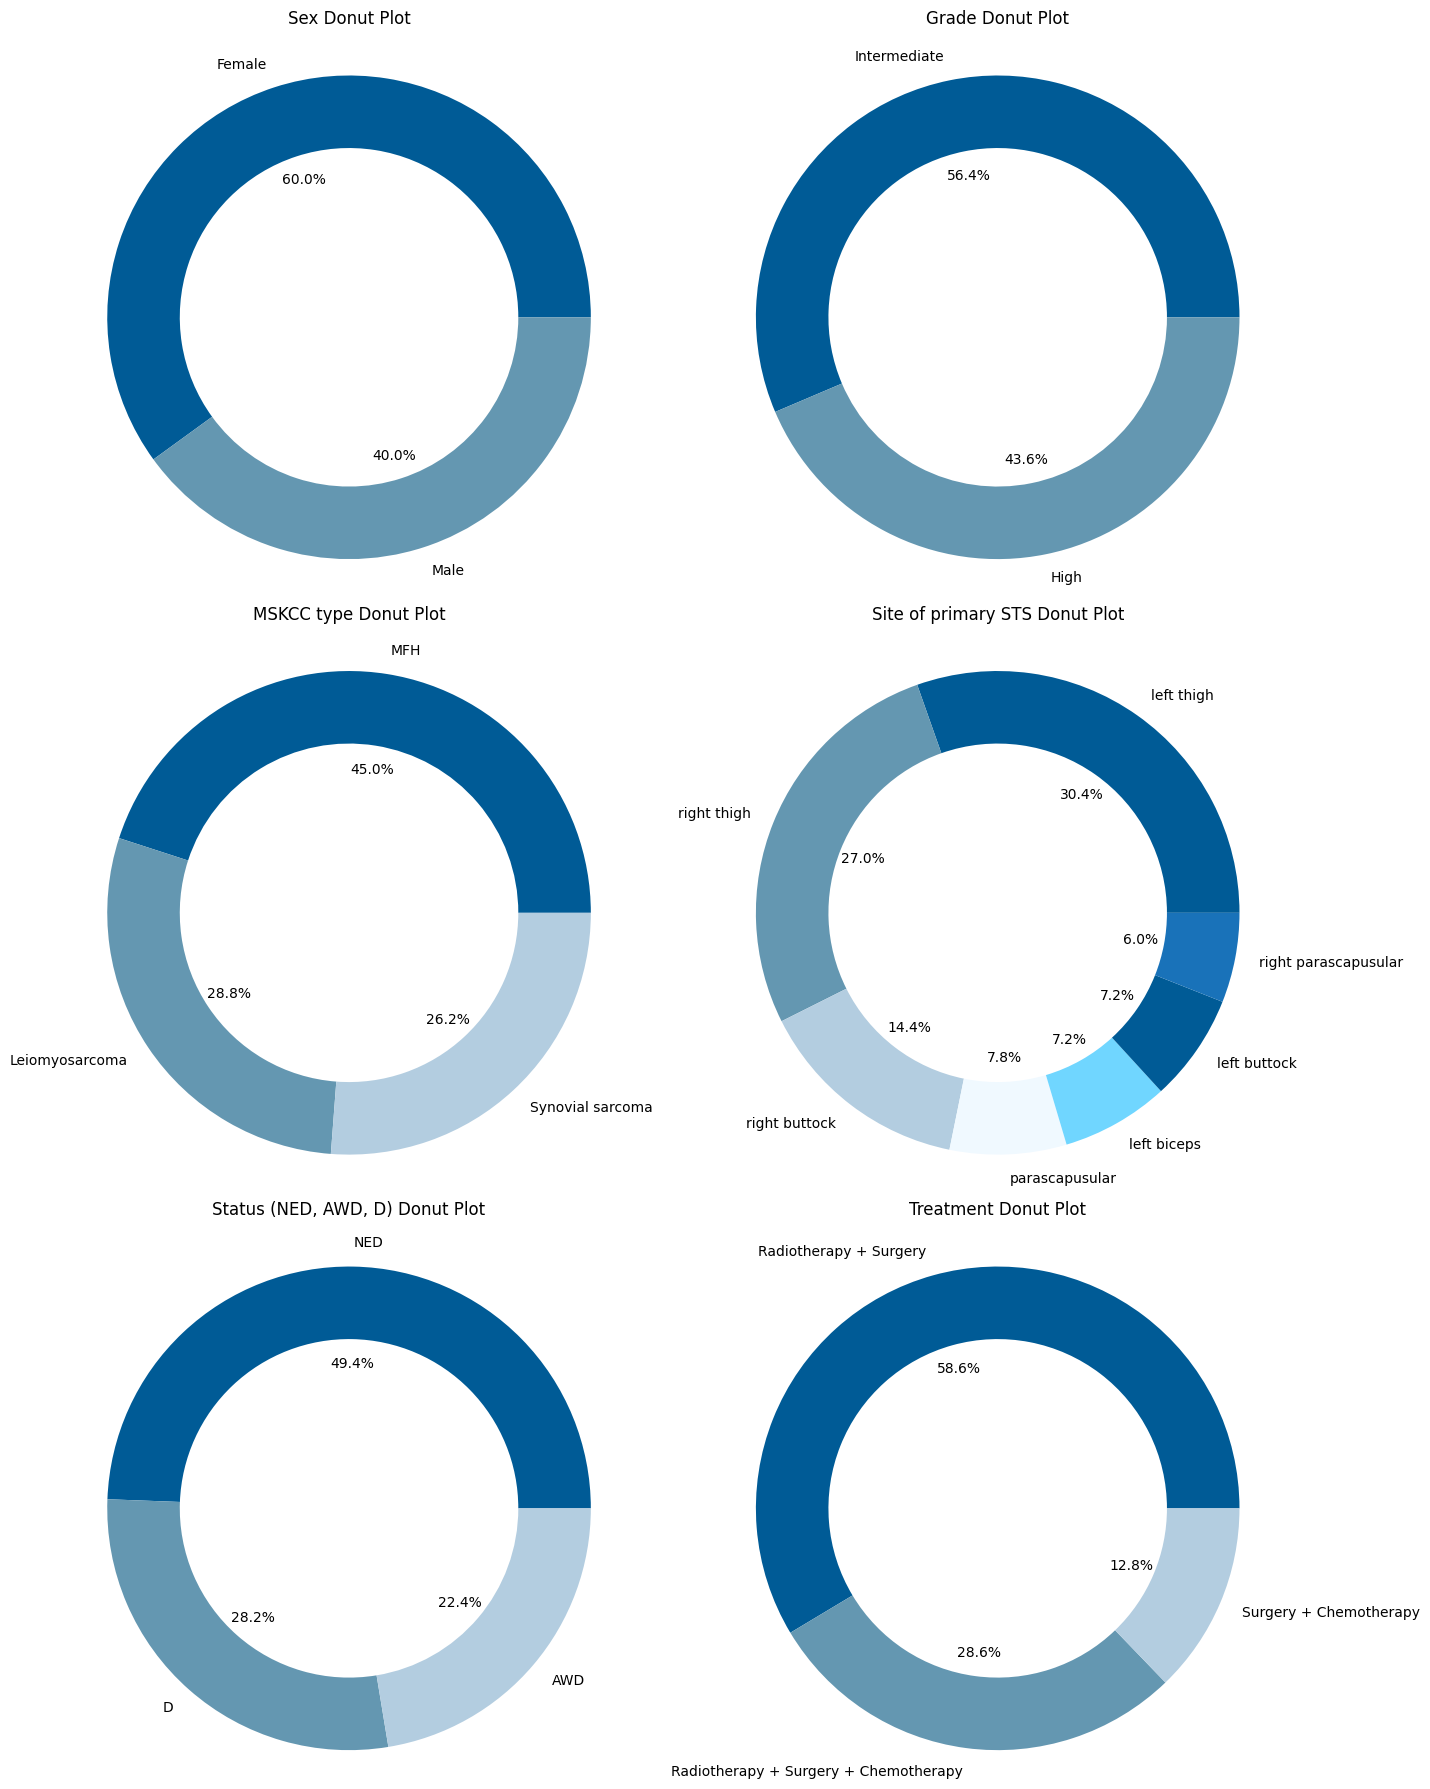

In [15]:
cat_cols = ['Sex', 'Grade', 'MSKCC type',
       'Site of primary STS', 'Status (NED, AWD, D)', 'Treatment']

n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

plt.figure(figsize=(14, 6 * n_rows))

for idx, column in enumerate(cat_cols):
    plt.subplot(n_rows, n_cols, idx + 1)

    category_counts = df[column].value_counts()
    labels = category_counts.index
    sizes = category_counts.values

    plt.Circle((0, 0), 0.70, color='white')
    percentages = (sizes / sizes.sum()) * 100

    wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=customPalette, wedgeprops=dict(width=0.3))
    plt.title(f"{column} Donut Plot", pad=20)
    plt.axis('equal')

    for i, autotext in enumerate(autotexts):
        autotext.set_text(f'{percentages[i]:.1f}%')

plt.tight_layout()
plt.show()


<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
<b>📉 Pie Plot :</b>
 Another way to understand the value count of the data in a visual way is through visualizing pie plots of different categorical values.

In [16]:
df["Sex"] = df["Sex"].map({'Female':0,'Male':1})

<b> 'Female'</b> : 0 &&
<b> 'Male' </b> : 1

In [17]:
categ_feats = ['Sex', 'Histological type', 'MSKCC type',
       'Site of primary STS', 'Status (NED, AWD, D)', 'Treatment']
df_encod = pd.get_dummies(df, columns=categ_feats, dtype=int)

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
<b>📉 Observation :</b>
notice that <b> Label Encoding</b>  was chosen over <b> One-Hot Encoding</b>  for the <b> "Grade"</b>  column because  "Grade" exhibits an ordinal relationship among its categories.

In [18]:
label_encoder = LabelEncoder()
df_encod['Grade'] = label_encoder.fit_transform(df_encod['Grade'])

In [19]:
df_encod.dtypes

Age                                                             int64
Grade                                                           int64
Sex_0                                                           int64
Sex_1                                                           int64
Histological type_epithelioid sarcoma                           int64
Histological type_leiomyosarcoma                                int64
Histological type_malignant solitary fibrous tumor              int64
Histological type_myxofibrosarcoma                              int64
Histological type_myxoid fibrosarcoma                           int64
Histological type_pleiomorphic leiomyosarcoma                   int64
Histological type_pleiomorphic spindle cell undifferentiated    int64
Histological type_pleomorphic sarcoma                           int64
Histological type_poorly differentiated synovial sarcoma        int64
Histological type_sclerosing epithelioid fibrosarcoma           int64
Histological type_sy

In [20]:
df_encod.isna().sum()

Age                                                             0
Grade                                                           0
Sex_0                                                           0
Sex_1                                                           0
Histological type_epithelioid sarcoma                           0
Histological type_leiomyosarcoma                                0
Histological type_malignant solitary fibrous tumor              0
Histological type_myxofibrosarcoma                              0
Histological type_myxoid fibrosarcoma                           0
Histological type_pleiomorphic leiomyosarcoma                   0
Histological type_pleiomorphic spindle cell undifferentiated    0
Histological type_pleomorphic sarcoma                           0
Histological type_poorly differentiated synovial sarcoma        0
Histological type_sclerosing epithelioid fibrosarcoma           0
Histological type_synovial sarcoma                              0
Histologic

no missing values cool

<a id = "3"></a><br>
# Model creation
***

In [21]:
X = df_encod.drop('Grade',axis=1)
y = df_encod['Grade']

In [22]:
print('The dimension of X:', X.shape)
print('The dimension of y:', y.shape)

The dimension of X: (500, 32)
The dimension of y: (500,)


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

<a id = "4.1"></a><br>

## XGBOOST

In [24]:
import xgboost as xgb
model = xgb.XGBRegressor(max_depth=10, learning_rate=0.05, n_estimators=50, objective='reg:linear', booster='gbtree')
XGB=model.fit(X_train,y_train)
prediction=XGB.predict(X_test)
r_prediction = np.where(prediction > 0.5, 1, 0)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, r_prediction)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.66


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:55:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


<a id = "4.2"></a><br>
# XGBOOST Confusion Matrix

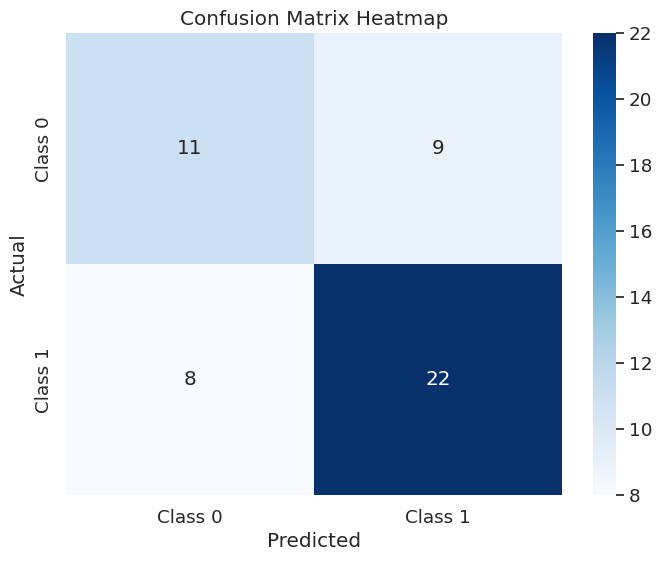

In [25]:
cm = confusion_matrix(y_test, r_prediction)

class_labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

<div style="border-radius: 10px; border: #ff001c  solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
<b>📉 Observation :</b>
    <ul>
<li><b>True Positives (TP)</b> : There are 23 instances that belong to the positive class (usually the minority class) and are correctly classified as such.</li>
<li><b>True Negatives (TN)</b> : There are 12 instances that belong to the negative class (usually the majority class) and are correctly classified as such.</li>
<li><b>False Positives (FP)</b> : There are 8 instances that actually belong to the negative class but are incorrectly classified as positive. </li>
<li><b>False Negatives (FN)</b> : There are 7 instances that actually belong to the positive class but are incorrectly classified as negative.</li>
    </ul>
    


lets try another model

<a id = "4.3"></a><br>
# KNeighborsClassifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)
pred_2 = knn.predict(X_test)
score = knn.score(X_test, y_test)
print("Accuracy Score:", score)

Accuracy Score: 0.8


<a id = "4.4"></a><br>
# KNN Confusion Matrix

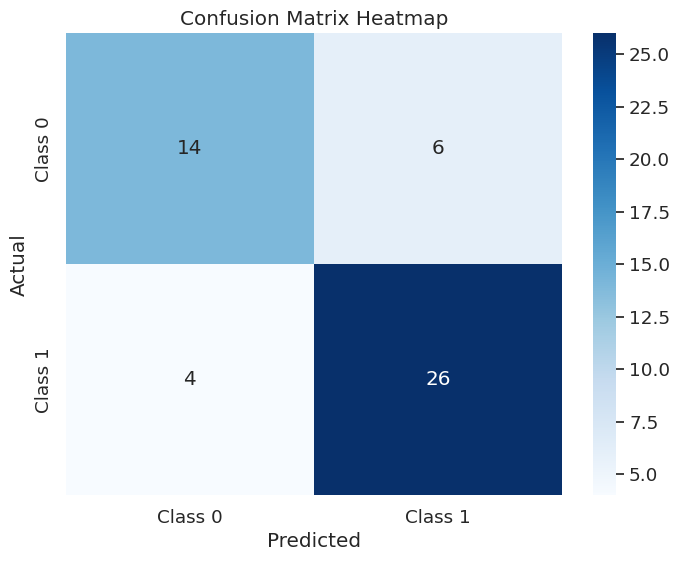

In [27]:
cm2 = confusion_matrix(y_test, pred_2)

class_labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

<div style="border-radius: 10px; border: #00d65c  solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b>
    <ul>
        <li><b>True Positives (TP)</b>: There are 26 instances that belong to the positive class and are correctly classified as such.</li>
        <li><b>True Negatives (TN)</b>: There are 14 instances that belong to the negative class and are correctly classified as such.</li>
        <li><b>False Positives (FP)</b>: There are 6 instances that actually belong to the negative class but are incorrectly classified as positive.</li>
        <li><b>False Negatives (FN)</b>: There are 4 instances that actually belong to the positive class but are incorrectly classified as negative.</li>
    </ul>
</div>


Much better, around 0.8 accuracy. I am aiming for an even higher accuracy. So lets try scaling the data

In [28]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


Scaling seems to not help that much. But i legt it for you if you want to try

In [29]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsClassifier

# param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
#     'p': [1, 2, 3, 4],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
# }

# knn_model = KNeighborsClassifier()

# grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(X_train_scaled, y_train)

# best_knn_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# print("Best Hyperparameters:", best_params)

In [30]:
# best_hyperparameters = {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

# knn_model = KNeighborsClassifier(**best_hyperparameters)
# knn_model.fit(X_train, y_train)

# y_pred_best = knn_model.predict(X_test)

# best_score = knn_model.score(X_test, y_test)
# print("Accuracy Score:", best_score)

In [31]:
# knn = KNeighborsClassifier(n_neighbors=20).fit(X_train, y_train)
# pred_2 = knn.predict(X_test)
# score = knn.score(X_test, y_test)
# print("Accuracy Score:", score)

<a id = "4.5"></a><br>
# RandomForestClassifier

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred = best_rf_model.predict(X_test)

In [33]:
scorerf = best_rf_model.score(X_test, y_test)
print("Accuracy Score:", scorerf)

Accuracy Score: 0.76


<a id = "4.6"></a><br>

# RF Confusion Matrix

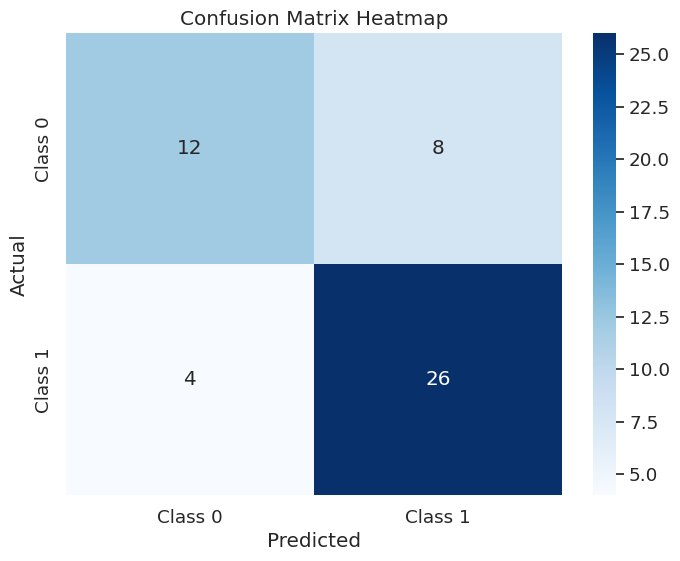

In [34]:
cm3= confusion_matrix(y_test, y_pred)

class_labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

<div style="border-radius: 10px; border: #ff001c   solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b>
    <ul>
        <li><b>True Positives (TP)</b>: There are 26 instances that belong to the positive class and are correctly classified as such.</li>
        <li><b>True Negatives (TN)</b>: There are 12 instances that belong to the negative class and are correctly classified as such.</li>
        <li><b>False Positives (FP)</b>: There are 8 instances that actually belong to the negative class but are incorrectly classified as positive.</li>
        <li><b>False Negatives (FN)</b>: There are 4 instances that actually belong to the positive class but are incorrectly classified as negative.</li>
    </ul>
</div>


<a id = "4.7"></a><br>
# Hyperparameter gidsearch

In [35]:
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30],
}

knn_model = KNeighborsClassifier()
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_hyperparameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_hyperparameters)
print("Best Accuracy Score:", best_score)

Best Hyperparameters: {'algorithm': 'kd_tree', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best Accuracy Score: 0.7511111111111111


In [36]:
hyperparameters = {
    'n_neighbors': 110,
    'algorithm': 'kd_tree',
    'leaf_size': 30,
    'metric': 'manhattan',
    'weights': 'distance',
    'p': 2,
    'n_jobs': -1
}

knn_model2222 = KNeighborsClassifier(**hyperparameters)
knn_model2222.fit(X_train, y_train)

predknn = knn_model2222.predict(X_test)

scoreAA = knn_model2222.score(X_test, y_test)
print("Accuracy Score:", scoreAA)


Accuracy Score: 0.8


<a id = "4.8"></a><br>
# Best Score Confusion Matrix

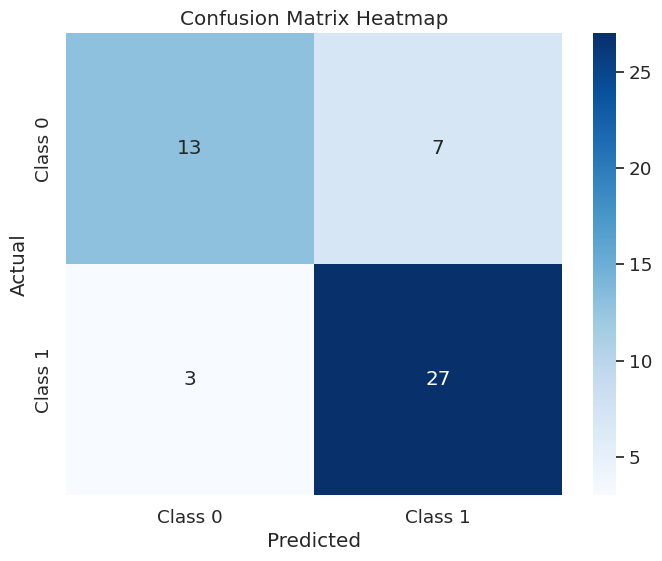

In [37]:
cm4= confusion_matrix(y_test, predknn)

class_labels = ["Class 0", "Class 1"]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm4, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

<div style="border-radius: 10px; border: #00d65c  solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📉 Observation :</b>
    <ul>
        <li><b>True Positives (TP)</b>: There are 26 instances that belong to the positive class and are correctly classified as such.</li>
        <li><b>True Negatives (TN)</b>: There are 14 instances that belong to the negative class and are correctly classified as such.</li>
        <li><b>False Positives (FP)</b>: There are 7 instances that actually belong to the negative class but are incorrectly classified as positive.</li>
        <li><b>False Negatives (FN)</b>: There are 3 instances that actually belong to the positive class but are incorrectly classified as negative.</li>
    </ul>
</div>


<a id = "5"></a><br>
# Conclusion

<div style="background-color: #d7dcff; border-left: 6px solid #0ea5e9; font-size: 100%; padding: 10px;">
    <h3 style="color: #27374D; font-size: 18px; margin-top: 0; margin-bottom: 10px;">🔎  conclusion</h3>
    <ul>
        <li><strong>xgboost:</strong> Accuracy Score: 0.7 ,for its strong predictive performance, it appears to perform slightly less accurately on your dataset compared to the other models tested.</li>
        <li><strong>knn:</strong> Accuracy Score: 0.8, KNN is known for its simplicity and can work well when the underlying data has clear patterns based on nearest neighbors</li>
        <li><strong>RandomForest:</strong> Accuracy Score: 0.76, RandomForest achieved an accuracy score that falls between the accuracy scores of the other models tested.</li>
    </ul>
</div>


<div style="border-radius: 15px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 220%; text-align: left;">
<b> 📊 Thanks for reading!</b>
</div>
